In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("../data/final/final.csv")

In [3]:
df.season.unique()

array([2018, 2019, 2020, 2022, 2023, 2024, 2025, 2021])

In [4]:
df.isna().sum()

player               0
league               0
team                 0
nation               0
general_position     0
                    ..
height(cm)           0
weight(kg)           0
value(€)             0
wage(€)              0
release_clause(€)    0
Length: 224, dtype: int64

In [5]:
# Fixed TRAINING_FEATURES - remove duplicates with FEATURES_EXCLUDE
TRAINING_FEATURES = [
    # Demographics & physical - REMOVED skill_moves, international_reputation (they're excluded)
    
    # Playing time
    "Playing_Time_Min",
    "Playing_Time_90s",
    "Starts_Starts",

    # Attacking output (per 90)
    "Per_90_Minutes_Gls",
    "Per_90_Minutes_Ast",
    "Per_90_Minutes_G+A",
    "Per_90_Minutes_xG",
    "Per_90_Minutes_xAG",
    "Per_90_Minutes_npxG",

    # Shooting efficiency
    "Standard_SoT%",
    "Standard_G/Sh",
    "Expected_npxG/Sh",
    "Expected_G-xG",

    # Passing & creativity
    "KP",
    "Ast",
    "Total_PrgDist",
    "Progression_PrgP",
    "SCA_SCA90",
    "GCA_GCA90",

    # Carrying
    "Carries_PrgDist",
    "Carries_1/3",
    "Take-Ons_Succ",

    # Defensive contribution
    "Tkl+Int",
    "Int",
    "Blocks_Blocks",
    "Aerial_Duels_Won",

    # Discipline / reliability
    "Performance_CrdY",
    "Performance_CrdR",
    "Err",

    # Team context
    "Team_Success_PPM",
    "Team_Success_+/-90",
    "Team_Success_(xG)_xG+/-90"
]



TARGETS = [
    # Scoring threat (finishing quality & volume)
    "Per_90_Minutes_npxG",
    "Per_90_Minutes_xG",
    "Standard_Sh/90",

    # Creativity & chance creation
    "Per_90_Minutes_xAG",
    "KP",
    "SCA_SCA90",

    # Ball progression & buildup value
    "Progression_PrgP",
    "Progression_PrgC",
    "Carries_PrgDist",

    # Defensive contribution
    "Tkl+Int",
    "Blocks_Blocks",
    "Aerial_Duels_Won",

    # Involvement / usage
    "Touches_Touches",
    "Receiving_Rec",
]

# Keep FEATURES_EXCLUDE as is
FEATURES_EXCLUDE = [
    'player', 'season', 'team', 'nation', 'born', 'league', 'age',
    'height(cm)', 'weight(kg)', 'foot', 'general_position', 'best_position'
]

In [6]:
# Fix: Aggregate data per player-season (combine stats from multiple teams)
def aggregate_player_season(df):
    """Aggregate stats for players who played for multiple teams in same season"""
    
    # Identify numeric columns to sum/average
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    # Remove identifier columns
    numeric_cols = [c for c in numeric_cols if c not in ['season']]
    
    # Categorical columns to take the last value (most recent team)
    cat_cols = ['team', 'league', 'nation', 'born', 'foot', 'general_position', 'best_position']
    
    agg_dict = {}
    
    # Sum numeric stats
    for col in numeric_cols:
        agg_dict[col] = 'sum'
    
    # Take last value for categorical
    for col in cat_cols:
        if col in df.columns:
            agg_dict[col] = 'last'
    
    # Group by player-season and aggregate
    df_agg = df.groupby(['player', 'season']).agg(agg_dict).reset_index()
    
    return df_agg

df_clean = aggregate_player_season(df)

def make_samples(df, window, features_exclude, target_cols):
    """
    Create samples with lagged features for time series prediction.
    Each player gets exactly ONE row per target season.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with player-season data
    window : int
        Number of historical seasons to use as features
    features_exclude : list
        Columns to exclude from lagging
    target_cols : list
        Target variables to predict
    
    Returns:
    --------
    pd.DataFrame
        Dataset with lagged features and targets
    """
    
    df = df.copy()
    df.sort_values(['player', 'season'], inplace=True)

    rows = []
    
    for player, g in df.groupby('player'):
        g = g.reset_index(drop=True)
        if len(g) <= window:
            continue
            
        # For each possible target season
        for i in range(window, len(g)):
            past = g.loc[i-window:i-1].copy()  # Historical seasons
            target_season = g.loc[i].copy()  # Target season
            
            flat = {}
            
            # Create lagged features
            for j, (_, r) in enumerate(past.iterrows(), start=1):
                suffix = f"_lag{window-j+1}"
                for c in TRAINING_FEATURES:  # Only lag training features
                    if c in features_exclude or c not in r.index:
                        continue
                    flat[c + suffix] = r[c]
            
            # Add static features from most recent season (no lag)
            flat['height(cm)'] = g.loc[i-1, 'height(cm)']
            flat['weight(kg)'] = g.loc[i-1, 'weight(kg)']
            flat['foot'] = g.loc[i-1, 'foot']
            flat['general_position'] = g.loc[i-1, 'general_position']
            flat['best_position'] = g.loc[i-1, 'best_position']
            
            # Add metadata
            flat['player'] = player
            flat['season_target'] = target_season['season']
            flat['age_at_target'] = g.loc[i-1, 'age'] + 1
            flat['team_last'] = g.loc[i-1, 'team']
            flat["league_last"] = g.loc[i-1, 'league']

            # Add targets
            for tcol in target_cols:
                if tcol in target_season.index:
                    flat[tcol] = target_season[tcol]
            
            rows.append(flat)
    
    return pd.DataFrame(rows)



# Create samples
df_samples = make_samples(
    df=df_clean,
    window=3,
    features_exclude=FEATURES_EXCLUDE,
    target_cols=TARGETS
)

In [7]:
lagged_cols = [c for c in df_samples.columns if 'lag' in c]
target_cols = [c for c in df_samples.columns if c in TARGETS]
static_cols = [c for c in df_samples.columns if c not in lagged_cols + target_cols and c not in ['player']]

In [8]:
df_samples = df_samples[['player'] +static_cols + lagged_cols + target_cols]

# Training

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd

In [11]:
# Handle categorical vairables

categorical_features = ['foot', 'general_position', 'best_position', 'team_last', 'league_last']
le_dict = {}

X = df[feature_cols].copy()
y = df[TARGETS].copy()

# Encode categorical variables
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    le_dict[col] = le

In [12]:
feature_cols = lagged_cols + [
    'height(cm)', 'weight(kg)', 'foot', 'general_position', 'best_position',
    'age_at_target', 'team_last', 'league_last'
]


df_clean_train = df_samples.dropna(subset=TARGETS).copy()
print(f"Samples after removing missing targets: {len(df_clean_train)}")


df = df_clean_train.copy()
for target in TARGETS:
    season_means = df.groupby('season_target')[target].mean()
    for season in season_means.index:
        mask = df['season_target'] == season
        df.loc[mask, target] = df.loc[mask, target] / season_means[season]

# Split the normalized data
train_mask = df['season_target'] < 2024
test_mask = df['season_target'] >= 2024

X_train_norm = X[train_mask]
y_train_norm = df.loc[train_mask, TARGETS]
X_test_norm = X[test_mask] 
y_test_norm = df.loc[test_mask, TARGETS]

Samples after removing missing targets: 3743


In [13]:
# 3. Train/test split by season
print("\n📊 Splitting data by season...")
train_mask = df['season_target'] < 2024
test_mask = df['season_target'] >= 2024

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print(f"Training samples: {X_train.shape[0]} (seasons < 2024)")
print(f"Test samples: {X_test.shape[0]} (seasons >= 2024)")


📊 Splitting data by season...
Training samples: 2199 (seasons < 2024)
Test samples: 1544 (seasons >= 2024)


In [14]:
print("\n⚙️ Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


⚙️ Scaling features...


In [15]:
# 5. Train Multi-output model
model_simple = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=50,      # Fewer trees
    max_depth=10,         # Limit depth
    min_samples_split=20, # More conservative splits
    min_samples_leaf=10,  # Larger leaf sizes
    random_state=42,
    n_jobs=-1
))

model_simple.fit(X_train_scaled, y_train)


,estimator estimator: estimator objectAn estimator object implementing :term:`fit` and :term:`predict`.,RandomForestR...ndom_state=42)
,"n_jobs n_jobs: int or None, optional (default=None)The number of jobs to run in parallel.:meth:`fit`, :meth:`predict` and :meth:`partial_fit` (if supportedby the passed estimator) will be parallelized for each target.When individual estimators are fast to train or predict,using ``n_jobs > 1`` can result in slower performance dueto the parallelism overhead.``None`` means `1` unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all available processes / threads.See :term:`Glossary ` for more details... versionchanged:: 0.20 `n_jobs` default changed from `1` to `None`.",None
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",50
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",20
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",10
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least 

In [16]:
# 6. Evaluate model_simple
print("\n📈 Evaluating model_simple...")
y_pred_train = model_simple.predict(X_train_scaled)
y_pred_test = model_simple.predict(X_test_scaled)


results = []
for i, target in enumerate(TARGETS):
    train_mae = mean_absolute_error(y_train.iloc[:, i], y_pred_train[:, i])
    test_mae = mean_absolute_error(y_test.iloc[:, i], y_pred_test[:, i])
    train_r2 = r2_score(y_train.iloc[:, i], y_pred_train[:, i])
    test_r2 = r2_score(y_test.iloc[:, i], y_pred_test[:, i])
    
    results.append({
        'target': target,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    })


📈 Evaluating model_simple...


In [17]:
results_df = pd.DataFrame(results)
print("\n🎯 Model Performance:")
results_df


🎯 Model Performance:


,target,train_mae,test_mae,train_r2,test_r2
0,Per_90_Minutes_npxG,0.292296,0.451858,0.757984,0.373610
1,Per_90_Minutes_xG,0.296629,0.439238,0.766896,0.426606
2,Standard_Sh/90,0.234176,0.348295,0.731105,0.431568
3,Per_90_Minutes_xAG,0.319115,0.456716,0.695982,0.393416
4,KP,0.345419,0.491970,0.723234,0.457799
5,SCA_SCA90,0.193802,0.279132,0.754009,0.507157
6,Progression_PrgP,0.317115,0.456617,0.685594,0.373806
7,Progression_PrgC,0.351572,0.510034,0.707037,0.431317
8,Carries_PrgDist,0.320693,0.453547,0.669246,0.361940
9,Tkl+Int,0.309565,0.432088,0.640428,0.357120


# Visualization of loss function, etc...

## Alternative 1: Random Forest with Out-of-Bag (OOB) Scoring
**Model:** `RandomForestRegressor` with `oob_score=True` and `warm_start=True`
**Purpose:** Track ensemble performance as trees are added incrementally
**Key Features:**
- Uses bootstrap sampling to evaluate performance on out-of-bag samples
- Shows diminishing returns as more trees are added
- No separate validation set needed
- Efficient way to monitor Random Forest convergence

**Parameters:**
- n_estimators: 10 → 100 (incremental)
- max_depth: 10
- min_samples_split: 20
- min_samples_leaf: 10

🌲 VISUALIZING RANDOM FOREST PERFORMANCE


/Users/lionlucky7/01.Projects/In-progress/soccer_prediction/.venv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


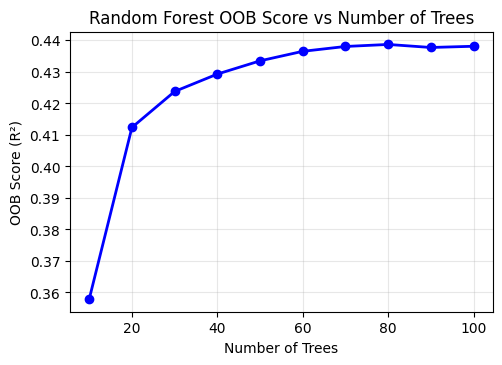

In [20]:
# =============================================================================
# ALTERNATIVE 1: Out-of-Bag (OOB) Score Progression
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

print("🌲 VISUALIZING RANDOM FOREST PERFORMANCE")
print("="*50)

# Train RF with OOB scoring enabled
rf_with_oob = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    oob_score=True,
    warm_start=True,  # Allows incremental fitting
    n_jobs=-1
)

# Train incrementally to track OOB progression
oob_scores = []
n_estimators_range = range(10, 101, 10)

for n_est in n_estimators_range:
    rf_with_oob.set_params(n_estimators=n_est)
    rf_with_oob.fit(X_train_scaled, y_train)
    oob_scores.append(rf_with_oob.oob_score_)

# Plot OOB score progression
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(n_estimators_range, oob_scores, 'b-o', linewidth=2, markersize=6)
plt.xlabel('Number of Trees')
plt.ylabel('OOB Score (R²)')
plt.title('Random Forest OOB Score vs Number of Trees')
plt.grid(True, alpha=0.3)

## Alternative 2: Cross-Validation Performance Curves
**Model:** Multiple `RandomForestRegressor` instances (120 total models)
**Purpose:** Evaluate generalization performance across multiple targets
**Key Features:**
- 3-fold cross-validation for robust estimates
- Tests 4 different target variables simultaneously
- Shows validation performance vs number of trees
- Most computationally expensive but most reliable

**Training Matrix:**
- 4 targets × 10 n_estimator values × 3 CV folds = 120 models
- Targets: `Per_90_Minutes_npxG`, `Per_90_Minutes_xAG`, `Tkl+Int`, `SCA_SCA90`


KeyboardInterrupt: 

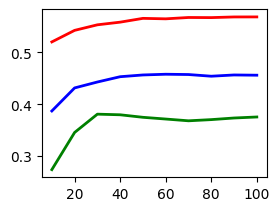

In [21]:
# =============================================================================
# ALTERNATIVE 2: Validation Curve for Each Target
# =============================================================================

from sklearn.model_selection import validation_curve

# Pick a few key targets to avoid clutter
key_targets = ['Per_90_Minutes_npxG', 'Per_90_Minutes_xAG', 'Tkl+Int', 'SCA_SCA90']

plt.subplot(2, 2, 2)
colors = ['red', 'blue', 'green', 'orange']

for i, target in enumerate(key_targets):
    y_single = y_train[target]
    
    train_scores, val_scores = validation_curve(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        X_train_scaled, y_single,
        param_name='n_estimators',
        param_range=n_estimators_range,
        cv=3, scoring='r2'
    )
    
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    
    plt.plot(n_estimators_range, val_mean, 
             color=colors[i], linewidth=2, label=f'{target}')

plt.xlabel('Number of Trees')
plt.ylabel('Cross-Validation R²')
plt.title('Validation Performance by Target')
plt.legend(fontsize=8)
plt.grid(True, alpha=0.3)


## Alternative 3: Learning Curve Analysis
**Model:** Single `RandomForestRegressor` with cross-validation
**Purpose:** Determine if more training data would improve performance
**Key Features:**
- Tests performance across different training set sizes (10% to 100%)
- Shows training vs validation score gap
- Helps identify overfitting vs underfitting
- Uses one representative target (`Per_90_Minutes_npxG`)

**Training Sizes:** 10 different sizes from 10% to 100% of training data

KeyboardInterrupt: 

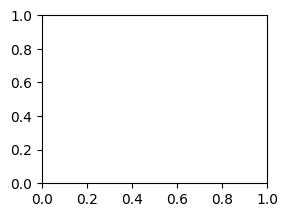

In [22]:
# =============================================================================
# ALTERNATIVE 3: Learning Curve (Sample Size vs Performance)
# =============================================================================

from sklearn.model_selection import learning_curve

plt.subplot(2, 2, 3)

# Use one representative target
target_idx = TARGETS.index('Per_90_Minutes_npxG')
y_single = y_train.iloc[:, target_idx]

train_sizes, train_scores_lc, val_scores_lc = learning_curve(
    RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    X_train_scaled, y_single,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=3, scoring='r2'
)

train_mean_lc = train_scores_lc.mean(axis=1)
train_std_lc = train_scores_lc.std(axis=1)
val_mean_lc = val_scores_lc.mean(axis=1)
val_std_lc = val_scores_lc.std(axis=1)

plt.plot(train_sizes, train_mean_lc, 'b-o', label='Training Score', linewidth=2)
plt.fill_between(train_sizes, train_mean_lc - train_std_lc, 
                 train_mean_lc + train_std_lc, alpha=0.1, color='blue')

plt.plot(train_sizes, val_mean_lc, 'r-o', label='Validation Score', linewidth=2)
plt.fill_between(train_sizes, val_mean_lc - val_std_lc, 
                 val_mean_lc + val_std_lc, alpha=0.1, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title(f'Learning Curve: {TARGETS[target_idx]}')
plt.legend()
plt.grid(True, alpha=0.3)

## Alternative 4: Feature Importance Stability Analysis
**Model:** Multiple `RandomForestRegressor` instances (5 models)
**Purpose:** Monitor feature ranking stability as ensemble grows
**Key Features:**
- Tracks variance in top-5 feature importance scores
- Shows when feature rankings stabilize
- Single target focus for simplicity
- Helps determine minimum trees needed for stable insights

**Tree Counts Tested:** [10, 25, 50, 75, 100]

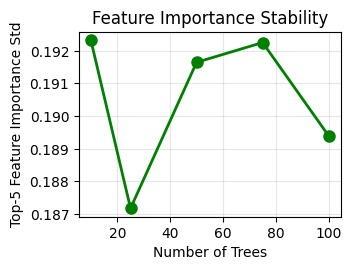

In [24]:
# =============================================================================
# ALTERNATIVE 4: Feature Importance Over Trees (Stability)
# =============================================================================

plt.subplot(2, 2, 4)

# Track feature importance stability
n_trees_to_test = [10, 25, 50, 75, 100]
importance_stability = []

for n_trees in n_trees_to_test:
    rf_temp = RandomForestRegressor(n_estimators=n_trees, random_state=42, n_jobs=-1)
    rf_temp.fit(X_train_scaled, y_train.iloc[:, target_idx])
    
    # Get top 5 feature importance variance
    importances = rf_temp.feature_importances_
    top_5_importance = np.sort(importances)[-5:].std()
    importance_stability.append(top_5_importance)

plt.plot(n_trees_to_test, importance_stability, 'g-o', linewidth=2, markersize=8)
plt.xlabel('Number of Trees')
plt.ylabel('Top-5 Feature Importance Std')
plt.title('Feature Importance Stability')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../visualizations/model_2/training/rf_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()



## Alternative 5: Gradient Boosting with True Loss Curves
**Model:** `GradientBoostingRegressor` (Sequential boosting model)
**Purpose:** Show true iterative loss minimization (unlike Random Forest)
**Key Features:**
- **Different algorithm entirely** - sequential tree building
- True training loss curve available via `train_score_`
- Validation loss calculated using `staged_predict()`
- Shows classic train/validation loss divergence patterns

**Parameters:**
- n_estimators: 100
- learning_rate: 0.1
- max_depth: 6

**Key Difference:** Gradient Boosting builds trees sequentially to minimize loss, while Random Forest builds trees independently in parallel.


🚀 BONUS: Using Gradient Boosting for Loss Visualization


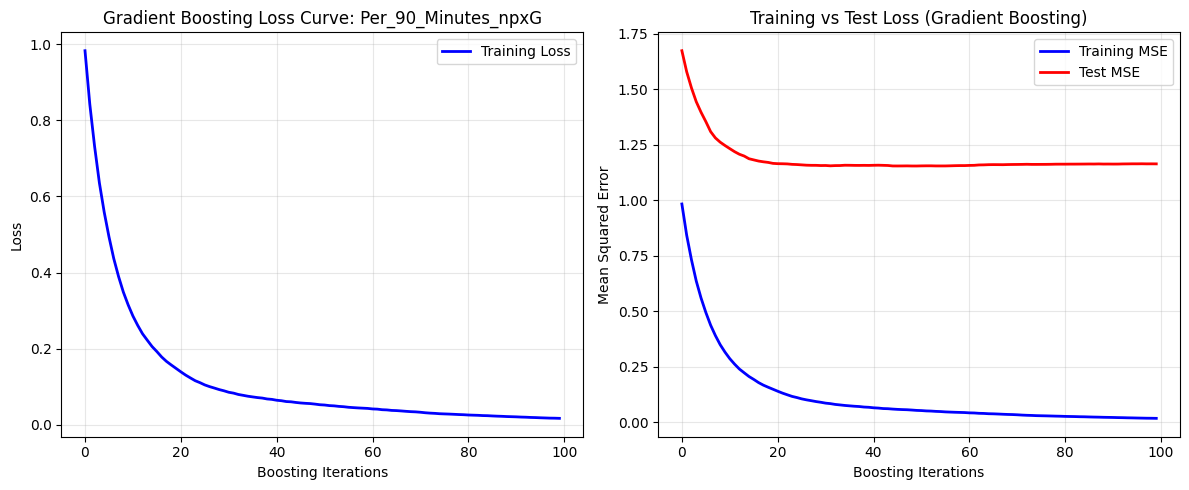

In [25]:
# =============================================================================
# ALTERNATIVE 5: Gradient Boosting for True Loss Visualization
# =============================================================================

print("\n🚀 BONUS: Using Gradient Boosting for Loss Visualization")

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

# Train a single target with GB to show loss curve
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Fit on single target to get loss curve
target_for_gb = 'Per_90_Minutes_npxG'
y_gb = y_train[target_for_gb]

gb_model.fit(X_train_scaled, y_gb)

# Plot training loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(gb_model.train_score_, 'b-', linewidth=2, label='Training Loss')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')
plt.title(f'Gradient Boosting Loss Curve: {target_for_gb}')
plt.legend()
plt.grid(True, alpha=0.3)

# Validation loss with test set
plt.subplot(1, 2, 2)
test_predictions = []
train_predictions = []

for i, pred in enumerate(gb_model.staged_predict(X_test_scaled)):
    test_loss = mean_squared_error(y_test[target_for_gb], pred)
    test_predictions.append(test_loss)

for i, pred in enumerate(gb_model.staged_predict(X_train_scaled)):
    train_loss = mean_squared_error(y_train[target_for_gb], pred)
    train_predictions.append(train_loss)

plt.plot(train_predictions, 'b-', linewidth=2, label='Training MSE')
plt.plot(test_predictions, 'r-', linewidth=2, label='Test MSE')
plt.xlabel('Boosting Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Training vs Test Loss (Gradient Boosting)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../visualizations/model_2/training/gradient_boosting_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# something